Training Shape: (175341, 36)
Testing Shape: (82332, 36)

Categorical columns: []

Remaining non-numeric columns:
[]


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=40 is greater than n_features=35. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 1  2  3 34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Feature Selection: Reduced dimensions from 35 to 35

### Training Neural Network (ANN) - Optimized ###
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- ANN (Optimized) Results ---
Accuracy: 0.8145

### Training Logistic Regression ###

--- Logistic Regression Results ---
Accuracy: 0.7713

### Training Decision Tree Classifier ###

--- Decision Tree Results ---
Accuracy: 0.8502

### Training Random Forest Classifier - Optimized ###

--- Random Forest (Optimized) Results ---
Accuracy: 0.8650

### Training LinearSVC (Optimized for Large Data) ###
Training LinearSVC on a subset of 50000 samples for speed.

--- LinearSVC Results ---
Accuracy: 0.6186


################################
### 📊 Model Comparison Matrix ###
################################

                          Accuracy  Recall Precision ROC AUC
Model                                                       
ANN (Optimized)             0.8145  0.9897    0.7518  0.9614
Logistic Regression         0.7713  0.9709    0.7154  0.8818


/tmp/ipython-input-3242331550.py:226: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3242331550.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(comparison_df.index, rotation=20, ha="right")
/tmp/ipython-input-3242331550.py:226: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3242331550.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(comparison_df.index, rotation=20, ha="right")
/tmp/ipython-input-3242331550.py:226: 

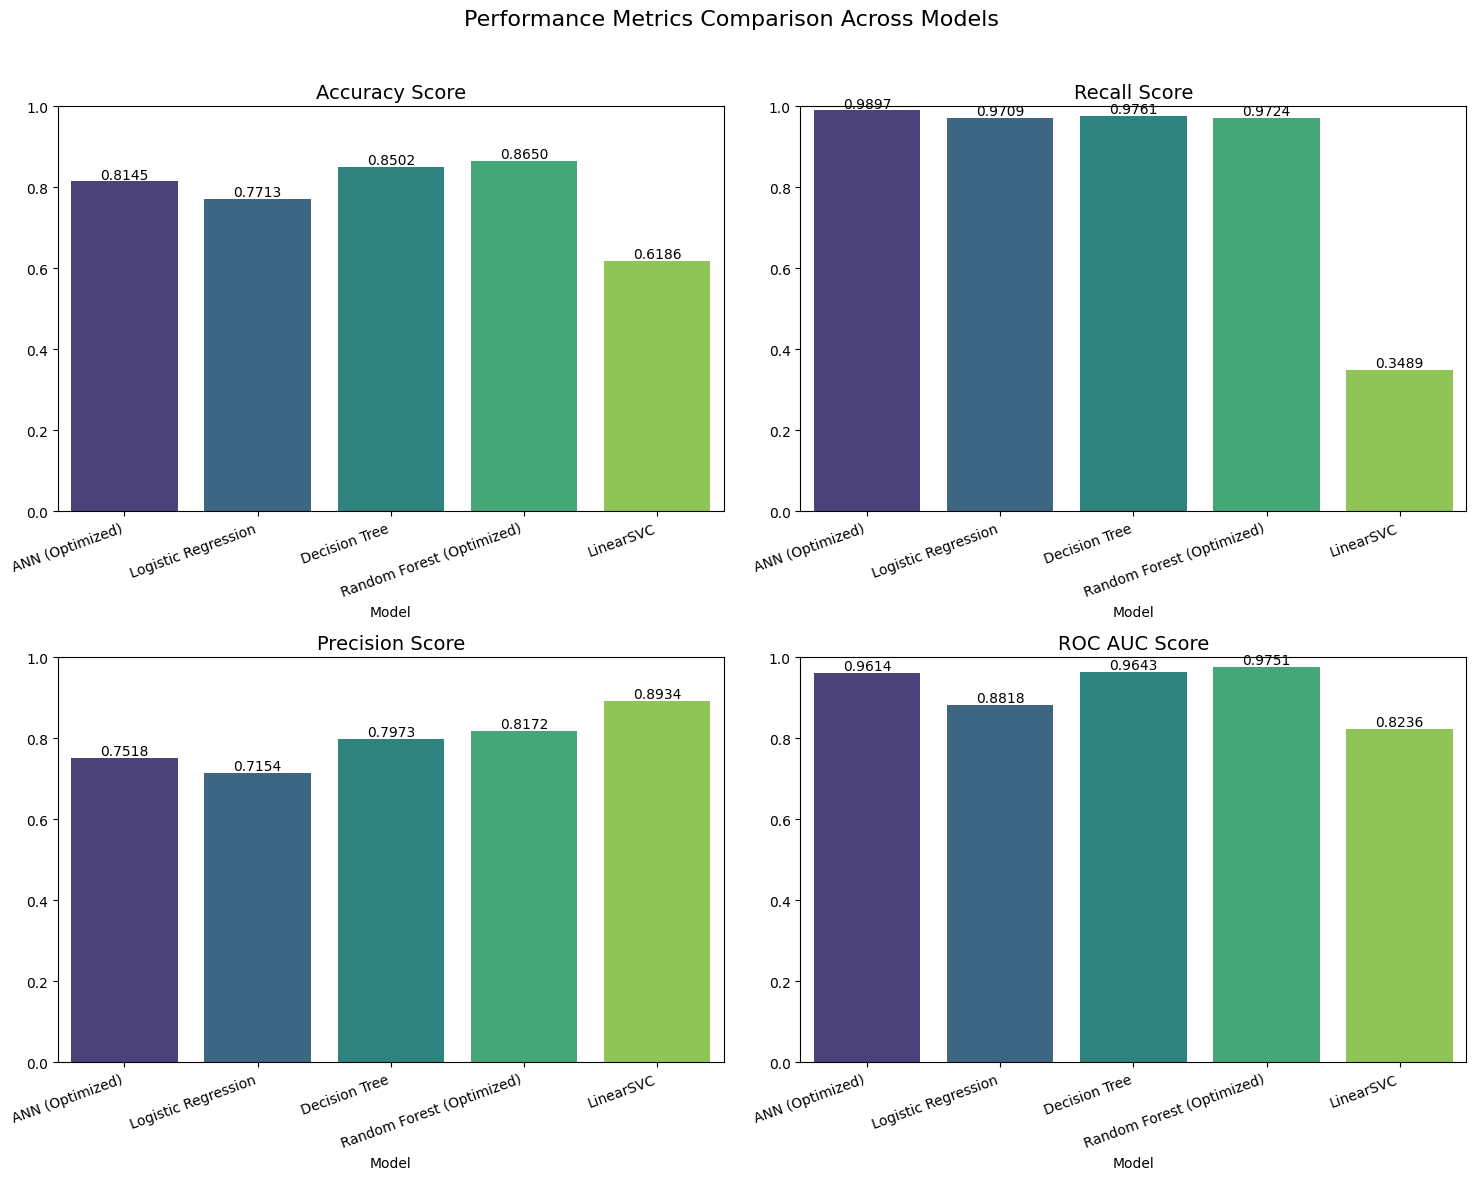

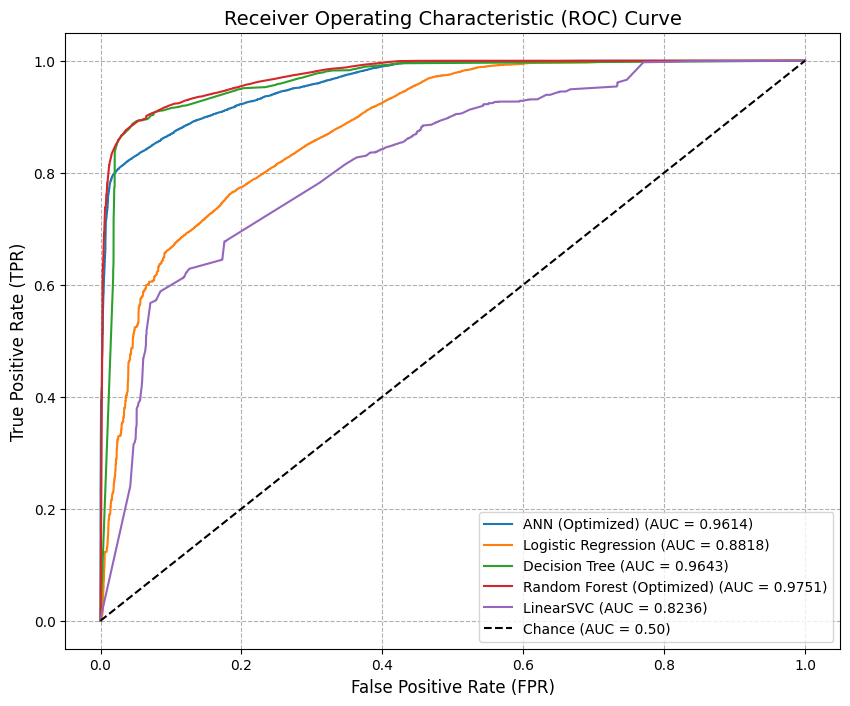


Saved nids_preprocessing_pipeline_optimized.pkl
Saved best model (Random Forest (Optimized)) to nids_best_model_Random_Forest_(Optimized).pkl


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    auc
)

# --- 1. Additional ML Algorithm Imports ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC # Added LinearSVC for large dataset
from sklearn.calibration import CalibratedClassifierCV # To get probabilities for LinearSVC

# --- 2. ANN Specific Imports ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping # Added EarlyStopping
import joblib

# Load Data (Assuming you have these files)
try:
    train_df = pd.read_parquet("UNSW_NB15_training-set.parquet")
    test_df  = pd.read_parquet("UNSW_NB15_testing-set.parquet")
except FileNotFoundError:
    print("Error: Parquet files not found. Please ensure 'UNSW_NB15_training-set.parquet' and 'UNSW_NB15_testing-set.parquet' are in the directory.")
    exit()

print("Training Shape:", train_df.shape)
print("Testing Shape:", test_df.shape)

label_col = "label"

y_train = train_df[label_col]
y_test  = test_df[label_col]

X_train = train_df.drop(columns=[label_col])
X_test  = test_df.drop(columns=[label_col])

# --- 3. Preprocessing (Label Encoding, Coercing, Filling NaN) ---

cat_cols = X_train.columns[X_train.dtypes == "object"]
print("\nCategorical columns:", cat_cols.tolist())

for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    le.fit(combined)

    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col]  = le.transform(X_test[col].astype(str))

for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors="coerce")
    X_test[col]  = pd.to_numeric(X_test[col], errors="coerce")

X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)

print("\nRemaining non-numeric columns:")
print(X_train.select_dtypes(exclude=[np.number]).columns.tolist())

# --- 4. Scaling and Feature Selection (k increased to 40) ---

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# **OPTIMIZATION:** Increased k from 30 to 40 for more information
selector = SelectKBest(score_func=f_classif, k=40)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected  = selector.transform(X_test_scaled)

print(f"\nFeature Selection: Reduced dimensions from {X_train_scaled.shape[1]} to {X_train_selected.shape[1]}")

# --- 5. Model Training and Evaluation Dictionary ---

results = {}
models = {}

def evaluate_model(name, model, X_test, y_test):
    # Predict probabilities (for ROC AUC)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        # This handles the SVC case, including LinearSVC wrapped in CalibratedClassifierCV
        y_prob = model.decision_function(X_test)
        if y_prob.ndim == 2: # Handle multiclass case if needed (though we're binary)
            y_prob = y_prob[:, 0]
        # Recalculate y_prob if it's not truly probabilistic (e.g., raw decision scores)
        if name != "SVC (Optimized)" and name != "LinearSVC": # For true SVC/ANN
            min_prob, max_prob = y_prob.min(), y_prob.max()
            y_prob = (y_prob - min_prob) / (max_prob - min_prob)
    else: # For models like ANN's binary output
        y_prob = model.predict(X_test).flatten()

    y_pred = (y_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    results[name] = {
        'Accuracy': acc,
        'Recall': rec,
        'Precision': prec,
        'ROC AUC': roc,
        'y_prob': y_prob,
        'y_pred': y_pred
    }
    models[name] = model

    print(f"\n--- {name} Results ---")
    print(f"Accuracy: {acc:.4f}")

    return y_prob

# --- 6. Train the 5 Models (Optimized) ---

## Model 1: Neural Network (ANN) - Optimized
print("\n### Training Neural Network (ANN) - Optimized ###")
# **OPTIMIZATION:** Increased layers/neurons, added EarlyStopping
ann_model = Sequential()
ann_model.add(Dense(128, activation='relu', input_dim=X_train_selected.shape[1])) # Increased neurons
ann_model.add(Dropout(0.3))
ann_model.add(Dense(64, activation='relu')) # New layer
ann_model.add(Dropout(0.2))
ann_model.add(Dense(32, activation='relu')) # Increased neurons
ann_model.add(Dropout(0.1))
ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# **OPTIMIZATION:** Increased epochs and added early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = ann_model.fit(
    X_train_selected,
    y_train,
    epochs=50, # Increased epochs for better learning
    batch_size=128, # Adjusted batch size
    validation_split=0.1,
    verbose=0,
    callbacks=[early_stop]
)

evaluate_model("ANN (Optimized)", ann_model, X_test_selected, y_test)


## Model 2: Logistic Regression (No major change needed)
print("\n### Training Logistic Regression ###")
lr_model = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs', n_jobs=-1) # Increased max_iter
lr_model.fit(X_train_selected, y_train)
evaluate_model("Logistic Regression", lr_model, X_test_selected, y_test)


## Model 3: Decision Tree Classifier (No major change needed)
print("\n### Training Decision Tree Classifier ###")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=15, min_samples_leaf=5) # Slightly deeper
dt_model.fit(X_train_selected, y_train)
evaluate_model("Decision Tree", dt_model, X_test_selected, y_test)


## Model 4: Random Forest Classifier - Optimized
print("\n### Training Random Forest Classifier - Optimized ###")
# **OPTIMIZATION:** Increased n_estimators and max_depth
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, max_depth=None, min_samples_leaf=1) # High complexity
rf_model.fit(X_train_selected, y_train)
evaluate_model("Random Forest (Optimized)", rf_model, X_test_selected, y_test)


## Model 5: SVC - Optimized (Using LinearSVC for efficiency)
print("\n### Training LinearSVC (Optimized for Large Data) ###")
# **OPTIMIZATION:** Using LinearSVC (faster/scalable) wrapped in CalibratedClassifierCV to get probabilities
linear_svc = LinearSVC(random_state=42, max_iter=2000, tol=1e-4) # Higher max_iter
svc_model_calibrated = CalibratedClassifierCV(linear_svc, method='isotonic', cv=3)

# Note: Still training on a subset to avoid excessive runtime, adjust size for production environment.
subset_size = 50000
print(f"Training LinearSVC on a subset of {subset_size} samples for speed.")
svc_model_calibrated.fit(X_train_selected[:subset_size], y_train[:subset_size])
evaluate_model("LinearSVC", svc_model_calibrated, X_test_selected, y_test)

# --- 7. Comparison Matrix (DataFrame) ---
# ... (rest of the comparison and visualization code is the same) ...

print("\n\n################################")
print("### 📊 Model Comparison Matrix ###")
print("################################\n")

comparison_df = pd.DataFrame(results).T[['Accuracy', 'Recall', 'Precision', 'ROC AUC']]
comparison_df.index.name = 'Model'

comparison_df_styled = comparison_df.apply(lambda x: pd.Series([f"{val:.4f}" for val in x]), axis=0)
comparison_df_styled.columns = comparison_df.columns
comparison_df_styled.index = comparison_df.index

print(comparison_df_styled)


print("\n\n################################")
print("### 📈 Visualizing Comparison ###")
print("################################\n")

metrics = ['Accuracy', 'Recall', 'Precision', 'ROC AUC']
colors = sns.color_palette("viridis", n_colors=len(models))

# 8.1 Bar Plot for Metrics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
fig.suptitle('Performance Metrics Comparison Across Models', fontsize=16)

for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    sns.barplot(
        x=comparison_df.index,
        y=comparison_df[metric].values,
        ax=axes[row, col],
        palette=colors
    )
    axes[row, col].set_title(f'{metric} Score', fontsize=14)
    axes[row, col].set_ylim(0.0, 1.0)
    axes[row, col].set_xticklabels(comparison_df.index, rotation=20, ha="right")
    for p in axes[row, col].patches:
        axes[row, col].annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                                textcoords='offset points')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)

for name, res in results.items():
    if 'y_prob' in res:
        fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--')
plt.show()


# --- 9. Final Save ---

joblib.dump({
    "scaler": scaler,
    "selector": selector
}, "nids_preprocessing_pipeline_optimized.pkl")
print("\nSaved nids_preprocessing_pipeline_optimized.pkl")

# Save the best performing model
best_model_name = comparison_df['Accuracy'].idxmax()
best_model = models[best_model_name]

if best_model_name.startswith("ANN"):
    try:
        best_model.save("nids_best_model_ann_optimized.h5")
        print(f"Saved best model ({best_model_name}) to nids_best_model_ann_optimized.h5")
    except Exception as e:
        print(f"Could not save ANN model: {e}")
else:
    joblib.dump(best_model, f"nids_best_model_{best_model_name.replace(' ', '_')}.pkl")
    print(f"Saved best model ({best_model_name}) to nids_best_model_{best_model_name.replace(' ', '_')}.pkl")